# 0. Imports

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import fixed
from geopy.geocoders import  Nominatim

### 0.1 Auxiliares

### 0.1.1 Formata números cientificos para as casas decimais, elimita a necessidade de ficar usando round

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# 1. Data collection

In [8]:
data = pd.read_csv('../data/kc_house_data.csv')

In [10]:
data = data.head(10) #dataset teste 
# Novas colunas
data['road'] = 'NA'
data['house_number'] = 'NA'
data['neighbourhood'] = 'NA'
data['city'] = 'NA'
data['country'] = 'NA'
data['state'] = 'NA'
data['osm'] = 'NA'

#Iniciar o nominatim
geolocator = Nominatim( user_agent='geoapiExercises')

for i in range( len(data)):
  query = str(data.loc[i, 'lat']) + ',' + str(data.loc[i,'long'])
  print(query)
  
  response = geolocator.reverse(query) #API Request

  #Populate data
  # if house number existir na tabela address ele executa a ação senão deixa NA
  if 'house_number' in response.raw['address']:
    data.loc[i, 'house_number'] = response.raw['address']['house_number']
  
  if 'road' in response.raw['address']:
    data.loc[i, 'road'] = response.raw['address']['road']
  
  if 'neighbourhood' in response.raw['address']:
    data.loc[i, 'neighbourhood'] = response.raw['address']['neighbourhood']
  
  if 'city' in response.raw['address']:
    data.loc[i, 'city'] = response.raw['address']['city']
  
  if 'country' in response.raw['address']:
    data.loc[i, 'country'] = response.raw['address']['country']
  
  if 'state' in response.raw['address']:
    data.loc[i, 'state'] = response.raw['address']['state']

  if 'osm_type' in response.raw:
    data.loc[i, 'osm'] = response.raw['osm_type']
print('fim')

47.5112,-122.257
47.721,-122.319
47.7379,-122.233
47.5208,-122.393
47.6168,-122.045
47.6561,-122.005
47.3097,-122.327
47.4095,-122.315
47.5123,-122.337
47.3684,-122.031
fim


In [55]:
report = data
report.to_csv('data/dataset.csv', index=False)

In [69]:
data = pd.read_csv('data/dataset.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,road,house_number,neighbourhood,city,country,state,osm
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,-122.26,1340,5650,61st Avenue South,10012.00,Rainier Beach,Seattle,United States,Washington,way
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,-122.32,1690,7639,Northeast 127th Street,837.00,NaN,Seattle,United States,Washington,way
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,-122.23,2720,8062,81st Avenue Northeast,15109.00,NaN,NaN,United States,Washington,node
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,-122.39,1360,5000,Fauntleroy Way Southwest,9236.00,NaN,Seattle,United States,Washington,way
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,-122.05,1800,7503,221st Avenue Northeast,923.00,NaN,NaN,United States,Washington,way


# 2. Data Preparation

In [70]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
road              object
house_number     float64
neighbourhood     object
city              object
country           object
state             object
osm               object
dtype: object

### 2.1.0 Converte o campo date e yr_built de objetct para date

In [71]:
data['date'] = pd.to_datetime(data['date'])
data['yr_built'] = pd.to_datetime( data['yr_built'], format='%Y') 

### 2.1.1 Exclusão das coluna 'sqft_living15' e 'sqft_lot15'

In [72]:
data.drop(['sqft_living15','sqft_lot15'],inplace=True, axis=1)

### 2.2.0 Classificação dos imóveis por idade
#### Data > 2015-01-01: New House || Data < 2015-01-01: Old House

In [73]:
data['house_age'] = 'age'

data.loc[data['date'] > '2015-01-01', 'house_age'] = 'new house'
data.loc[data['date'] <= '2015-01-01', 'house_age'] = 'old house'

### 2.2.1 Classificação de imóveis por número de quartos
#### 1 quarto: studio || 2 quartos: apartamento || 3 quartos: casa

In [74]:
data['dormitory_type'] = 'values'
data.loc[data['bedrooms'] == 1, 'dormitory_type'] = 'studio'
data.loc[data['bedrooms'] == 2, 'dormitory_type'] = 'apartament'
data.loc[data['bedrooms'] >= 3, 'dormitory_type'] = 'house'

### 2.2.2 Classificação dos imóveis pelo seu estado de conservação

In [75]:
data['condition_type'] = 'status'
data.loc[data['condition'] <= 2, 'condition_type'] = 'bad'
data.loc[(data['condition'] > 2) & (data['condition'] < 5), 'condition_type' ] = 'regular'
data.loc[data['condition'] >= 5, 'condition_type'] = 'good'

### 2.2.3 Classificação de imóveis por nivel de preço
###### Nivel 0: preço entre RS 0.00 e RS 321.950
###### Nivel 1: preço entre RS321.950 e RS 450.000
###### Nivel 2: preço entre RS 450.000 e RS 645.000
###### Nivel 3: preço acima de RS 645.000

In [76]:
for i in range(len(data)):
  if (data.loc[i, 'price'] > 0) & (data.loc[i, 'price'] < 321950):
    data.loc[i, 'nivel'] = 'nivel_0'
  
  elif (data.loc[i, 'price'] >= 321950) & (data.loc[i, 'price'] < 450000):
    data.loc[i, 'nivel'] = 'nivel_1'

  elif (data.loc[i, 'price'] >= 450000) & (data.loc[i, 'price'] < 645000):
    data.loc[i, 'nivel'] = 'nivel_2'
  
  else:
    data.loc[i, 'nivel'] = 'nivel_3'

# 3. Data exploration

## 3.1 Quantas casas estão disponíveis para compra?

In [77]:
df = pd.DataFrame(data)
print(df.shape[0])

500


## 3.2 Qual a casa mais cara do portifólio?

In [19]:
print(df[['id','price']].sort_values('price', ascending=False))

               id      price
7252   6762700020  7700000.0
3914   9808700762  7062500.0
9254   9208900037  6885000.0
4411   2470100110  5570000.0
1448   8907500070  5350000.0
...           ...        ...
8274   3883800011    82000.0
16198  3028200080    81000.0
465    8658300340    80000.0
15293    40000362    78000.0
1149   3421079032    75000.0

[21613 rows x 2 columns]


## 3.3 Quantas casas possuem dois banheiros?

In [20]:
sum(df.iloc[:,4] == 2)
print( df[df['bathrooms'] == 2].shape[0] )

1930


## 3.4 Quantas casas possuem mais de 300 metros quadrados na sala de estar?

In [21]:
df['m2_living'] = df['sqft_living']*0.092 # convert 1 pé = 0.092 m2
len(df.loc[df['m2_living'] > 300])

2141

## 3.5 Das casas com vista para o mar, quantas tem 3 quartos?

In [23]:
len(df.loc[(df.waterfront == 1) & (df.bedrooms == 3)])

64

## 3.6 Quantos imóveis estão em condição 'bad' e possuem 'vista para água'?

In [25]:
data.loc[(data['condition_type'] == 'bad') & (data['waterfront'] == 1)].shape[0]

2

## 3.7 Qual o número de imóveis por ano de construção?

In [26]:
group_year = data[['id', 'yr_built']].groupby('yr_built')
for year, propriety in group_year:
  print('Número de imóveis construidos em {} é: {}'.format(year, propriety.shape[0]))

Número de imóveis construidos em 1900-01-01 00:00:00 é: 87
Número de imóveis construidos em 1901-01-01 00:00:00 é: 29
Número de imóveis construidos em 1902-01-01 00:00:00 é: 27
Número de imóveis construidos em 1903-01-01 00:00:00 é: 46
Número de imóveis construidos em 1904-01-01 00:00:00 é: 45
Número de imóveis construidos em 1905-01-01 00:00:00 é: 74
Número de imóveis construidos em 1906-01-01 00:00:00 é: 92
Número de imóveis construidos em 1907-01-01 00:00:00 é: 65
Número de imóveis construidos em 1908-01-01 00:00:00 é: 86
Número de imóveis construidos em 1909-01-01 00:00:00 é: 94
Número de imóveis construidos em 1910-01-01 00:00:00 é: 134
Número de imóveis construidos em 1911-01-01 00:00:00 é: 73
Número de imóveis construidos em 1912-01-01 00:00:00 é: 79
Número de imóveis construidos em 1913-01-01 00:00:00 é: 59
Número de imóveis construidos em 1914-01-01 00:00:00 é: 54
Número de imóveis construidos em 1915-01-01 00:00:00 é: 64
Número de imóveis construidos em 1916-01-01 00:00:00 é:

## 3.8 Qual o tamanho médio da salas dos imóveis por ano de contrução?

In [27]:
average_living = data[['yr_built','sqft_living']].groupby('yr_built').mean()
average_living

,sqft_living
yr_built,
1900-01-01,1732.011494
1901-01-01,1763.620690
1902-01-01,1919.629630
1903-01-01,1507.739130
1904-01-01,1603.177778
...,...
2011-01-01,2313.684615
2012-01-01,2378.741176
2013-01-01,2636.592040


## 3.9 Qual o tamanho mediano das salas dos imóveis por ano de contrução?

In [28]:
median_living = data[['yr_built', 'sqft_living']].groupby('yr_built').median()
median_living

,sqft_living
yr_built,
1900-01-01,1540.0
1901-01-01,1610.0
1902-01-01,1600.0
1903-01-01,1505.0
1904-01-01,1280.0
...,...
2011-01-01,2270.0
2012-01-01,2237.5
2013-01-01,2580.0


## 3.10 Qual o desvio-padrão do tamanho das salas do imóveis por ano de construção?

In [29]:
desviation_living = data[['yr_built', 'sqft_living']].groupby('yr_built').std() 
desviation_living

,sqft_living
yr_built,
1900-01-01,732.944373
1901-01-01,668.231804
1902-01-01,878.659300
1903-01-01,469.723438
1904-01-01,1076.870620
...,...
2011-01-01,804.863521
2012-01-01,771.430350
2013-01-01,883.499390


## 3.11 Quantos imóveis existem por número de quartos?

In [35]:
df_grouped = data[['id','bedrooms']].groupby('bedrooms')
for bedrooms, frame in df_grouped:
  print('Número de quartos {}'.format( bedrooms))
  print(frame.shape[0], end='\n\n')

Número de quartos 0
13

Número de quartos 1
199

Número de quartos 2
2760

Número de quartos 3
9824

Número de quartos 4
6882

Número de quartos 5
1601

Número de quartos 6
272

Número de quartos 7
38

Número de quartos 8
13

Número de quartos 9
6

Número de quartos 10
3

Número de quartos 11
1

Número de quartos 33
1



## 3.12 Análise do crescimento médio de preço de compra de imóveis por ano, semana e dia

### Crescimento médio de preços de compras de imóveis por ano
##### eixo X = anos , eixo Y: soma dos preços

<BarContainer object of 2 artists>

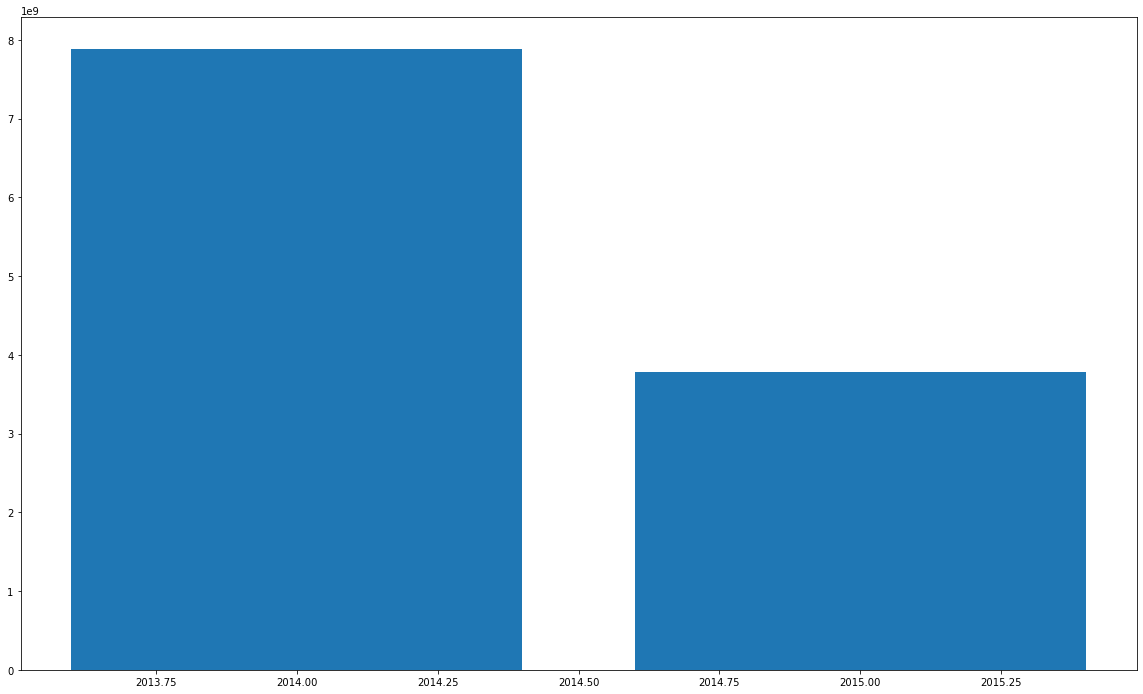

In [31]:
data['year'] = pd.to_datetime(data['date']).dt.year #função dt.year retorna apenas o ano
by_year = data[['price', 'year']].groupby('year').sum().reset_index() #reset index coloca
plt.figure( figsize=(20, 12)) #dimensionando 
plt.bar(by_year['year'], by_year['price'])

### Crescimento médio de preços de compras de imóveis por semana
##### eixo X = anos , eixo Y: soma dos preços

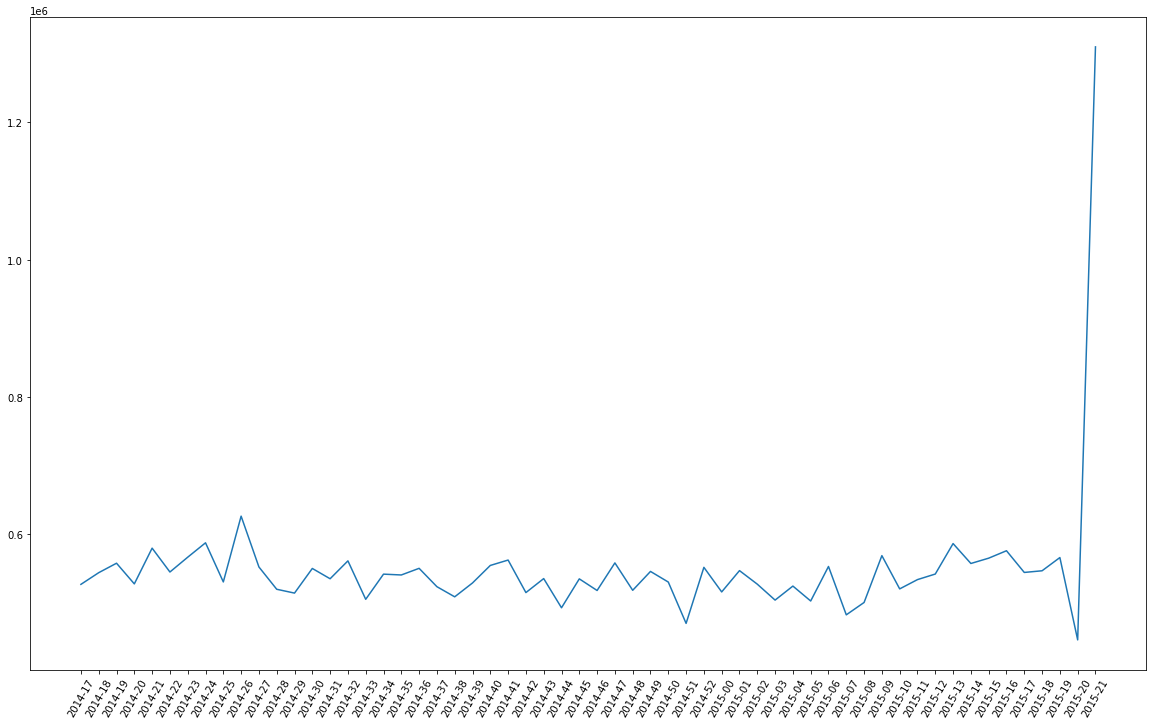

In [33]:
data['year_week'] = pd.to_datetime(data['date']).dt.strftime('%Y-%W')
by_week = data[['price', 'year_week']].groupby('year_week').mean().reset_index() #reset index coloca

plt.figure( figsize=(20, 12)) #dimensionando 
plt.plot(by_week['year_week'], by_week['price'])
plt.xticks( rotation=60);

### Crescimento médio de preços de compras de imóveis por dia
##### eixo X = anos , eixo Y: soma dos preços

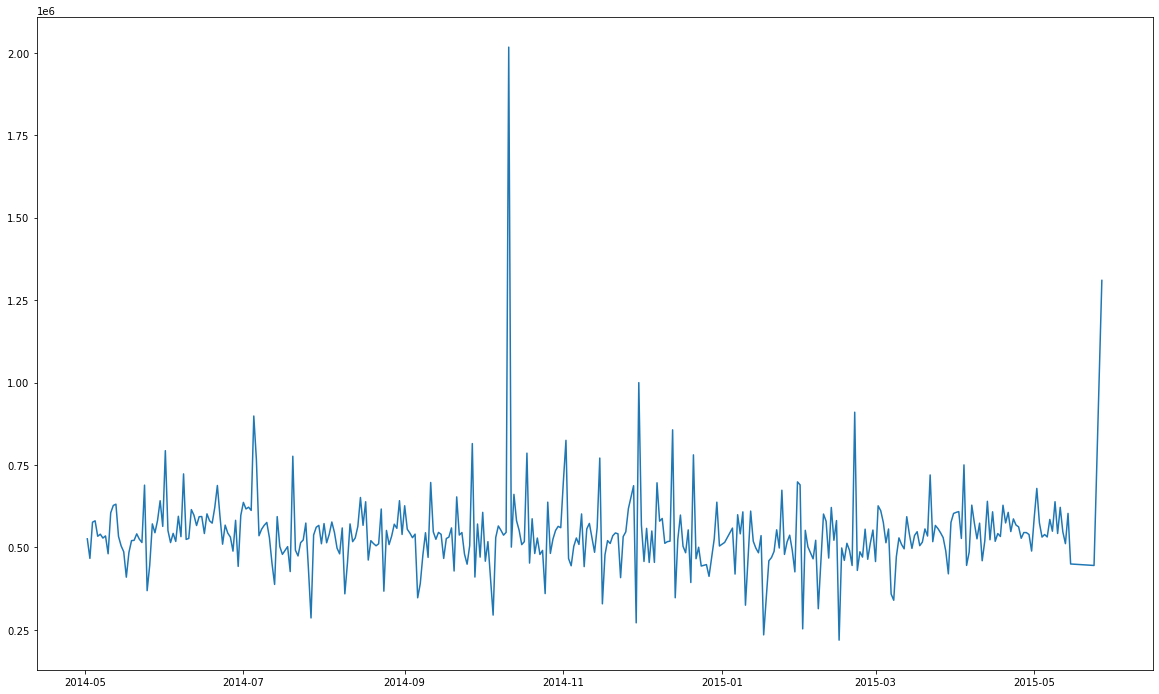

In [32]:
data['day'] = pd.to_datetime(data['date'])
by_day = data[['price', 'day']].groupby('day').mean().reset_index() #reset index coloca

plt.figure( figsize=(20, 12)) #dimensionando 
plt.plot(by_day['day'], by_day['price'])

## 3.13 Média dos preços por ano de construção dos imóveis

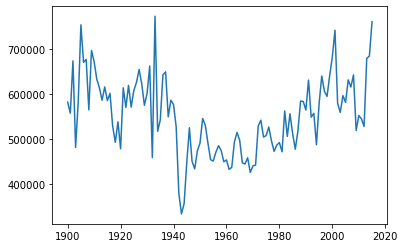

In [36]:
group_mean = data[['price','yr_built']].groupby('yr_built').mean().reset_index()
plt.plot(group_mean['yr_built'], group_mean['price'])

## 3.14 Média de preços por tipo de dormitórios

<BarContainer object of 4 artists>

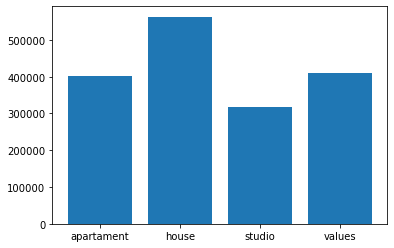

In [37]:
mean_bed = data[['dormitory_type', 'price']].groupby('dormitory_type').mean().reset_index()
plt.bar(mean_bed['dormitory_type'], mean_bed['price'])

## 3.15 Evolução da média dos preços pelo ano da reforma dos imóveis a partir do ano de 1930

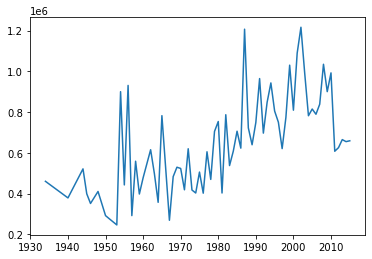

In [38]:
filtro = ['yr_renovated','price']
mean_ref = data[(data.yr_renovated > 1929)][filtro].groupby('yr_renovated').mean().reset_index()
plt.plot(mean_ref['yr_renovated'], mean_ref['price'])

## 3.16 Mapa com a localização das casas

In [64]:
data_mapa = data[['id','lat','long','price']]
mapa = px.scatter_mapbox(data_mapa, lat='lat' ,lon='long' , hover_name='id', hover_data=['price'], color_discrete_sequence=['green'], zoom=8, height=300)
mapa.update_layout(mapbox_style='open-street-map')
mapa.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
mapa.show()